In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import pickle
import os
import osmnx as ox
from pyrosm import OSM

PROCESS FLOW

1. Download census tract data from https://www2.census.gov/geo/tiger/TIGER2024/BG/; note id from https://www2.census.gov/geo/tiger/TIGER_RD18/STATE/
2. Download OSM data for a given state here https://download.geofabrik.de/north-america/us.html
3. Download ACS data from https://data.census.gov/table/ACSDT5Y2022.B19013; filter to "every block group in {county of target city}; save as acs_city folder, rename nothing inside
4. Run the following code block to process data
5. Add new city to list of cities in graph code, run graph code

In [2]:
cities_to_ids = {
    "newyork": 36,
    "losangeles": "06",
    "chicago": 17,
    "houston": 48,
    "phoenix": "04",
    "philadelphia": 42,
    "sanantonio": 48,
    "sandiego": "06",
    "dallas": 48,
    "jacksonville": 12,
    "austin": 48,
    "fortworth": 48, 
    "sanjose": "06",
    "columbus": 39,
    "charlotte": 37,
    "indianapolis": 18,
    "sanfrancisco": "06",
    "seattle": 53,
    "denver": "08",
    "oklahomacity": 40,
    "nashville": 47,
    "washington": 11,
    "elpaso": 48,
    "lasvegas": 32,
    "boston": 25,
    "detroit": 26,
    "portland": 41,
    "louisville": 21,
    "memphis": 47,
    "baltimore": 24,
    "milwaukee": 55,
    "albuquerque": 35,
    "tucson": "04",
    "fresno": "06",
    "sacramento": "06",
    "mesa": "04", 
    "atlanta": 13,
    "kansascity": 29
}

cities_to_states = {
    "newyork": "new-york",
    "losangeles": "california",
    "chicago": "illinois",
    "houston": "texas",
    "phoenix": "arizona",
    "philadelphia": "pennsylvania",
    "sanantonio": "texas",
    "sandiego": "california",
    "dallas": "texas",
    "jacksonville": "florida",
    "austin": "texas",
    "fortworth": "texas", 
    "sanjose": "california",
    "columbus": "ohio",
    "charlotte": "north-carolina",
    "indianapolis": "indiana",
    "sanfrancisco": "california",
    "seattle": "washington",
    "denver": "colorado",
    "oklahomacity": "oklahoma",
    "nashville": "tennessee",
    "washington": "district-of-columbia",
    "elpaso": "texas",
    "lasvegas": "nevada",
    "boston": "massachusetts",
    "detroit": "michigan",
    "portland": "oregon",
    "louisville": "kentucky",
    "memphis": "tennessee",
    "baltimore": "maryland",
    "milwaukee": "wisconsin",
    "albuquerque": "new-mexico",
    "tucson": "arizona",
    "fresno": "california",
    "sacramento": "california",
    "mesa": "arizona", 
    "atlanta": "georgia",
    "kansascity": "missouri"
}

In [3]:
def convert_to_geojson(city, formal_city):
    # Define the path to the local OSM file
    city_fp = f"osm/{cities_to_states[city]}-latest.osm.pbf"

    # Load the OSM data locally
    osm = OSM(city_fp)

    # Define the boundaries of the city (using OSMnx to geocode)
    city_boundary = ox.geocode_to_gdf(f"{formal_city}, USA")
    print("Boundary defined")

    # Get the city boundary geometry
    city_geom = city_boundary.geometry.iloc[0]

    # Define the OSM tags you want to extract (all in one dictionary)
    tags = {
        "amenity": ["library", "fire_station", "bank", "place_of_worship", "pharmacy", "social_facility", "police", "community_centre"],
        "leisure": ["park"],
        "building": ["school", "hospital", "residential", "house", "apartments"],
        "landuse": ["residential"],
        "shop": ["supermarket"],
        "highway": ["bus_stop"]
    }

    # Perform a **single** call to get all features that match the tags
    gdf = osm.get_data_by_custom_criteria(custom_filter=tags, filter_type="keep")

    # Filter data to keep only those within the city boundary
    if gdf is not None and not gdf.empty:
        try:
            gdf = gdf[gdf.geometry.is_valid]
            gdf = gdf[gdf.intersects(city_geom)]
            gdf = gdf.drop(columns=["id", "timestamp"], errors="ignore")
            print("Data extracted successfully")
        except:
            invalid = gdf.loc[~gdf.geometry.is_valid]
            print(invalid)

        # Save to a GeoJSON file
        output_fp = f"buildings/{city}_buildings.geojson"
        gdf.to_file(output_fp, driver="GeoJSON")
        print(f"GeoJSON saved at {output_fp}")
    else:
        print("No data extracted for the specified tags.")


In [4]:
%%time
# GENERALIZABLE FUNCTION

def process_data(city, id):

    # Load the census tract shapefile
    census_tracts = gpd.read_file(f'tl/tl_2024_{id}_bg/tl_2024_{id}_bg.shp')
    
    # Load the OSM data (make sure it includes location data as points or polygons)
    osm_data = gpd.read_file(f'buildings/{city}_buildings.geojson')
        

    # Reproject if needed (make sure both are in the same CRS)
    osm_data = osm_data.to_crs(census_tracts.crs)
    
    # Perform the spatial join
    osm_with_geoid = gpd.sjoin(osm_data, census_tracts[['GEOID', 'geometry']], how='left')
    
    # Load the ACS data
    acs_data = pd.read_csv(f"acs/acs_{city}/ACSDT5Y2022.B19013-Data.csv")
    
    acs_data = acs_data.rename(columns={"B19013_001E": "MedHouseIncome"})
    acs_data["GEO_ID"] = acs_data["GEO_ID"].apply(lambda x: x[9:])
    acs_data["MedHouseIncome"] = acs_data["MedHouseIncome"].apply(lambda x: float('nan') if x == "-" else x)
    acs_data = acs_data.drop(0)

    # Filter to include only BG_ID_10 and MedHouseIncome columns
    acs_income = acs_data[['GEO_ID', 'MedHouseIncome']]
    
    acs_income = acs_income.astype(str)
    acs_income = acs_income.dropna(subset=["MedHouseIncome"])
    
    # Now merge the data
    combined_with_income = osm_with_geoid.merge(acs_income, left_on="GEOID", right_on="GEO_ID", how="left")

    combined_with_income = combined_with_income.dropna(subset=["MedHouseIncome"])
        
    return combined_with_income

CPU times: user 3 μs, sys: 0 ns, total: 3 μs
Wall time: 4.53 μs


In [5]:
%%time

cities = cities_to_ids.keys()

formal_cities = ["New York, New York", "Los Angeles, California", "Chicago, Illinois", "Houston, Texas", "Phoenix, Arizona", "Philadelphia, Pennsylvania", "San Antonio, Texas", "San Diego, California",
                 "Dallas, Texas", "Jacksonville, Florida", "Austin, Texas", "Fort Worth, Texas", "San Jose, California", "Columbus, Ohio", "Charlotte, North Carolina", "Indianapolis, Indiana", "San Francisco, California",
                 "Seattle, Washington", "Denver, Colorado", "Oklahoma City, Oklahoma", "Nashville, Tennessee", "Washington, District of Columbia", "El Paso, Texas", "Las Vegas, Nevada", "Boston, Massachusetts",
                 "Detroit, Michigan", "Portland, Oregon", "Louisville, Kentucky", "Memphis, Tennessee", "Baltimore, Maryland", "Milwaukee, Wisconsin", "Albuquerque, New Mexico", "Tucson, Arizona", "Fresno, California",
                 "Sacramento, California", "Mesa, Arizona", "Atlanta, Georgia", "Kansas City, Missouri"]

CPU times: user 2 μs, sys: 1e+03 ns, total: 3 μs
Wall time: 5.25 μs


In [6]:
# # %%time
# with open('dataframes.pkl', 'rb') as handle:
#     dataframes = pickle.load(handle)

# for city, formal_city in zip(cities_to_ids.keys(), formal_cities):
#     print("starting", city, formal_city)
#     if not os.path.exists(f"buildings/{city}_buildings.geojson"):
#         convert_to_geojson(city, formal_city)
#     dataframes[city] = process_data(city, cities_to_ids[city])
#     print(city, "complete! length", len(dataframes[city]))

Will be important to note - how many block groups have we calculated, vs how many exist?

Can also compare current income bins to expected income bins to get an idea for accuracy.

In [7]:
# with open('dataframes.pkl', 'wb') as handle:
#     pickle.dump(dataframes, handle)

In [8]:
with open('dataframes.pkl', 'rb') as handle:
    dataframes = pickle.load(handle)

In [9]:
print(len(dataframes))

38


newyork
losangeles
chicago
houston
phoenix
philadelphia
sanantonio
sandiego
dallas
jacksonville
austin
fortworth
sanjose
columbus
charlotte
indianapolis
sanfrancisco
seattle
denver
oklahomacity
nashville
washington
elpaso
lasvegas
boston
detroit
portland
louisville
memphis
baltimore
milwaukee
albuquerque
tucson
fresno
sacramento
mesa
atlanta
kansascity


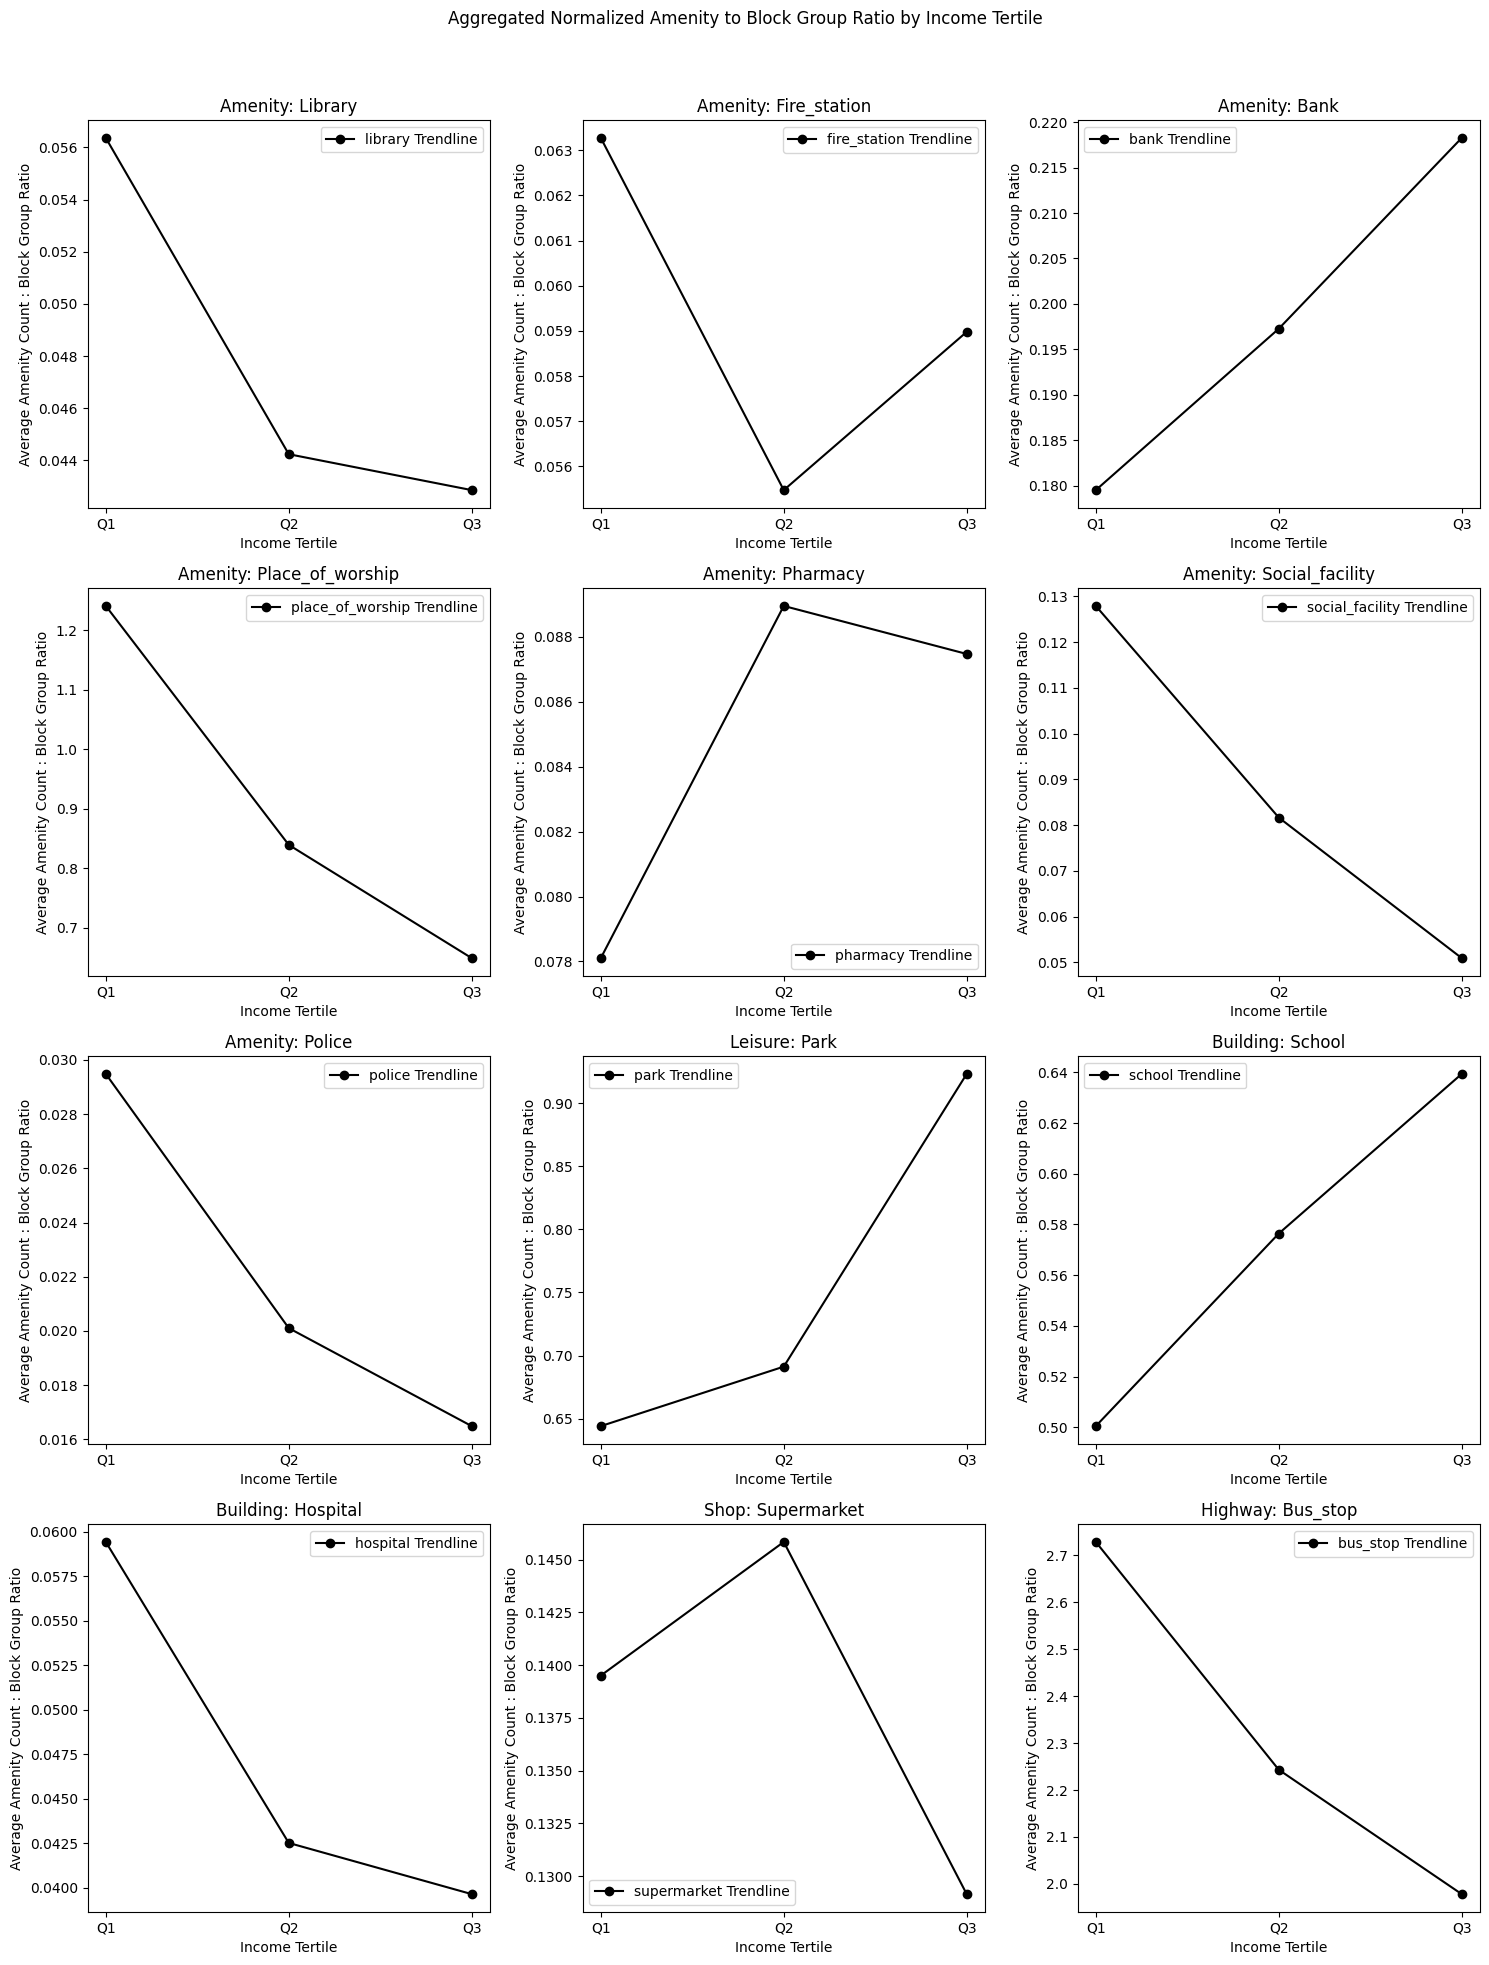

In [193]:
# Define the function to calculate normalized counts by income range for multiple cities and categories
def category_normalized_counts_by_income(categories, city_names, num_quintiles=3):
    all_results = {}

    # Process each city dataframe
    for city_name in city_names:
        
        print(city_name)
        
        df = dataframes[city_name]
        
        df.drop(['income_range'], axis=1, errors='ignore', inplace=True)
        
        # Ensure MedHouseIncome is numeric
        df["MedHouseIncome"] = pd.to_numeric(df["MedHouseIncome"], errors="coerce")
        
        # Drop rows where MedHouseIncome is NaN after conversion
        df = df.dropna(subset=["MedHouseIncome"])

        # Step 1: Calculate income tertiles based on unique block groups
        unique_bg = df.drop_duplicates(subset=["GEO_ID"])[["GEO_ID", "MedHouseIncome"]]
    
        unique_bg["income_range"], income_bins = pd.qcut(
            unique_bg["MedHouseIncome"], 
            q=num_quintiles, 
            retbins=True, 
            labels=[f"Q{i+1}" for i in range(num_quintiles)]
        )
        
        # Step 2: Count the number of block groups in each income range
        block_group_counts = unique_bg.groupby("income_range", observed=False).size().reset_index(name="bg_count") 

        # Step 3: Merge income range back to the main DataFrame
        df = pd.merge(df, unique_bg[["GEO_ID", "income_range"]], on="GEO_ID", how="left")
        city_results = {}
        for category, items in categories.items():
            category_results = {}
            for item in items:
                # Filter for rows where the feature matches the specified item in the category
                try:
                    filtered_data = df[df[category] == item]

                    # Count occurrences of the item per income range
                    counts_by_income = filtered_data.groupby("income_range", observed=False).size().reset_index(name="count")

                    # Merge with block group counts to get `bg_count` for each income range
                    counts_with_bg = pd.merge(counts_by_income, block_group_counts, on="income_range", how="left")

                    # Calculate the normalized count (service count per block group) across cities
                    counts_with_bg["normalized_count"] = counts_with_bg["count"] / counts_with_bg["bg_count"]

                    # Store the results for each item in the current category
                    category_results[item] = counts_with_bg[["income_range", "normalized_count"]]
                except:
                    continue
            
            # Store the category results in the main results dictionary for this city
            city_results[category] = category_results
        
        # Store all results for each city by name
        all_results[city_name] = city_results
        dataframes[city_name] = df
    
    return all_results, income_bins


# Function to calculate the **aggregated** average trendline per income tertile across all cities
def aggregate_city_trendlines(results, categories):
    aggregated_results = {}

    for category, items in categories.items():
        aggregated_results[category] = {}
        
        for item in items:
            # Collect all dataframes from different cities
            all_city_data = []
            
            for city_name, city_data in results.items():
                try:
                    all_city_data.append(city_data[category][item])
                except:
                    continue
            
            # Concatenate all dataframes together
            combined_df = pd.concat(all_city_data)
            
            # Compute the average normalized count per income tertile
            aggregated_df = combined_df.groupby("income_range", observed=False)["normalized_count"].mean().reset_index()
            
            # Store the aggregated results
            aggregated_results[category][item] = aggregated_df

    return aggregated_results

categories = {
    "amenity": ["library", "fire_station", "bank", "place_of_worship", "pharmacy", "social_facility", "police"],
    "leisure": ["park"],
    "building": ["school", "hospital"],
    "shop": ["supermarket"],
    "highway": ["bus_stop"]
}

# List of city dataframes and corresponding names
city_names = list(cities_to_ids.keys())

# Run the function to get results and income bins
results, income_bins = category_normalized_counts_by_income(categories, city_names)

# Aggregate data for trendlines
aggregated_results = aggregate_city_trendlines(results, categories)

# Determine grid dimensions based on total items across all categories
total_items = sum(len(items) for items in categories.values())
cols = 3  # Number of columns in the grid
rows = math.ceil(total_items / cols)  # Calculate the number of rows required

# Plotting in a 2D grid
fig, axs = plt.subplots(rows, cols, figsize=(15, rows * 5))
fig.suptitle("Aggregated Normalized Amenity to Block Group Ratio by Income Tertile")

# Track the subplot index
plot_index = 0

# Loop through each category and item
for category, items in categories.items():
    for item in items:
        # Determine the current row and column based on plot_index
        row = plot_index // cols
        col = plot_index % cols
        ax = axs[row, col] if rows > 1 else axs[col]  # Handle single-row or multi-row cases

        # Plot aggregated data (single trendline per category)
        data = aggregated_results[category][item]
        ax.plot(data["income_range"], data["normalized_count"], marker='o', linestyle='-', label=f"{item} Trendline", color="black")

        # Set titles and labels for each subplot
        ax.set_title(f"{category.capitalize()}: {item.capitalize()}")
        ax.set_xlabel("Income Tertile")
        ax.set_ylabel("Average Amenity Count : Block Group Ratio")
        ax.legend()
        
        plot_index += 1

# Hide any unused subplots if the grid has extra cells
for j in range(plot_index, rows * cols):
    fig.delaxes(axs[j // cols, j % cols])

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the main title
plt.show()


In [194]:
classifications = {
    "quality-of-life": {
        "amenity": ["library", "place_of_worship"],
        "building": [],
        "leisure": ["park"],
        "shop": ["supermarket"],
        "highway": []
    },
    "economic-mobility": {
        "amenity": ["social_facility", "bank"],
        "building": ["school"],
        "leisure": [],
        "shop": [],
        "highway": ["bus_stop"]
    },
    "health-and-safety": {
        "amenity": ["fire_station", "police", "pharmacy"],
        "building": ["hospital"],
        "leisure": [],
        "shop": [],
        "highway": []
    }
}

📊 Amenity - library:
  Slope: 11.699
  Intercept: 2823.113
  R-squared: 0.070
  P-value: 6.661e-01
  Std Err: 24.536

📊 Amenity - fire_station:
  Slope: -97.294
  Intercept: 2288.391
  R-squared: 0.963
  P-value: 3.097e-03
  Std Err: 11.062

📊 Amenity - bank:
  Slope: -172.552
  Intercept: 2061.003
  R-squared: 0.991
  P-value: 3.689e-04
  Std Err: 9.542

📊 Amenity - place_of_worship:
  Slope: 49.814
  Intercept: 602.598
  R-squared: 0.964
  P-value: 2.991e-03
  Std Err: 5.597

📊 Amenity - pharmacy:
  Slope: -195.859
  Intercept: 2530.575
  R-squared: 0.971
  P-value: 2.075e-03
  Std Err: 19.417

📊 Amenity - social_facility:
  Slope: 12.280
  Intercept: 3509.940
  R-squared: 0.013
  P-value: 8.548e-01
  Std Err: 61.634

📊 Amenity - police:
  Slope: 38.165
  Intercept: 4787.448
  R-squared: 0.139
  P-value: 5.370e-01
  Std Err: 54.905

📊 Leisure - park:
  Slope: -26.088
  Intercept: 627.487
  R-squared: 0.954
  P-value: 4.202e-03
  Std Err: 3.295

📊 Building - school:
  Slope: -41.814
 

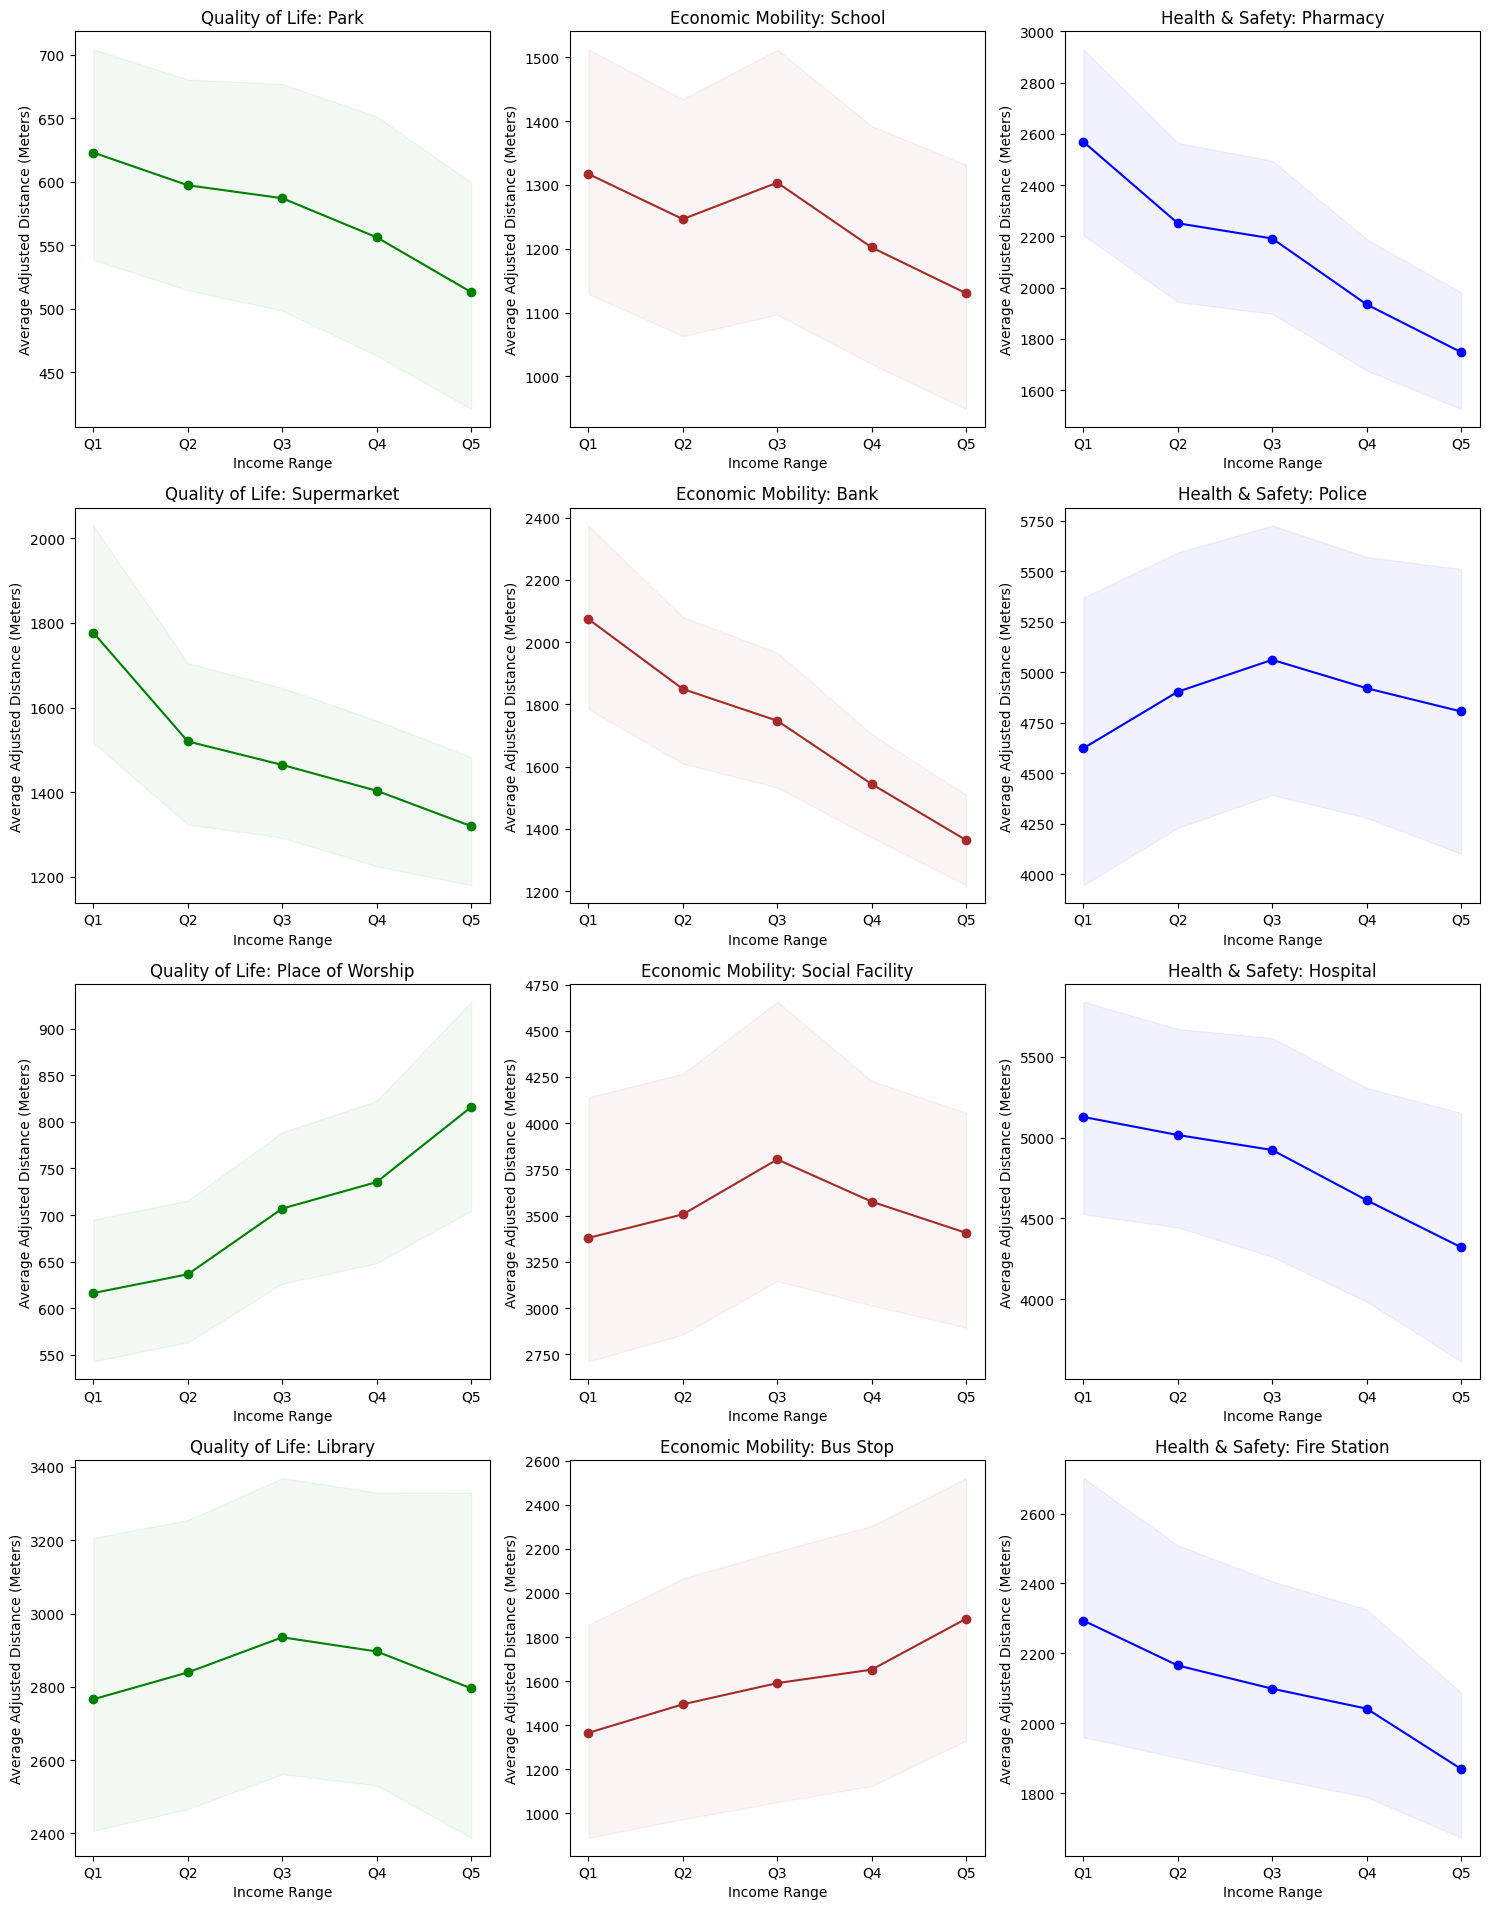

CPU times: user 1.33 s, sys: 109 ms, total: 1.44 s
Wall time: 1.45 s


In [195]:
%%time
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import geopandas as gpd
from shapely.wkt import loads as wkt_loads
from scipy.stats import linregress

import geopandas as gpd
import numpy as np
from shapely.wkt import loads as wkt_loads

def calculate_min_distances_block_group(df, city_name, categories, block_group_column="GEO_ID"):
    projected_crs = "EPSG:3857"
    results = {}

    # Convert WKT text to shapely geometry objects only if necessary
    if df["geometry"].dtype == "object":
        df["geometry"] = df["geometry"].apply(
            lambda geom: wkt_loads(geom) if isinstance(geom, str) else geom
        )

    df = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")

    # Reproject to the projected CRS for distance calculations
    df = df.to_crs(projected_crs)
    
    city_id = cities_to_ids[city_name]
    census_tracts = gpd.read_file(f'tl/tl_2024_{city_id}_bg/tl_2024_{city_id}_bg.shp')
    census_tracts = census_tracts.to_crs(epsg = "4269")
    census_tracts = census_tracts[["GEOID", "geometry"]]

    # Dissolve states by region

    block_group_areas = census_tracts.dissolve(by="GEOID")

    # Calculate area for each dissolved region
    
    block_group_areas = block_group_areas['geometry'].area.reset_index()

    block_group_areas.rename(columns={0: "block_group_area"}, inplace=True)
    
    block_group_areas.rename(columns={"GEOID": "GEO_ID"}, inplace=True)
    
    max_val = block_group_areas["block_group_area"].max()
    block_group_areas["norm_factor"] = 1 - (np.log1p(block_group_areas["block_group_area"]) / np.log1p(max_val))
    
    for category, items in categories.items():
        category_results = {}
        for item in items:
            # Filter amenities by category and item
            amenities = df[df[category] == item]
            amenities = gpd.GeoDataFrame(amenities, geometry="geometry").to_crs(projected_crs)
            amenities["geometry"] = amenities["geometry"].apply(
                lambda geom: geom.centroid if geom.geom_type == "Polygon" else geom
            )

            # Filter residential buildings for distance calculation
            residential_buildings = df[
                (df["building"].isin(["residential", "house", "apartments"])) |  
                (df["landuse"] == "residential")  
            ].copy()

            # Randomly sample one residence per block group
            sampled_residences = residential_buildings.groupby(block_group_column).sample(n=1, random_state=42)

            # Compute minimum distance from sampled residences to each amenity
            sampled_residences[f"min_dist_to_{item}"] = sampled_residences["geometry"].apply(
                lambda geom: amenities.distance(geom).min() if not amenities.empty else np.nan
            )

            # Merge with block group area data
            sampled_residences = sampled_residences.merge(block_group_areas, on=block_group_column, how="left")

            # Normalize distances by block group size
            sampled_residences[f"normalized_dist_to_{item}"] = (
                sampled_residences[f"min_dist_to_{item}"] / np.sqrt(sampled_residences["block_group_area"])
            )
            
            #sampled_residences[f"normalized_dist_to_{item}"] /= np.sqrt(block_group_areas["block_group_area"].mean())
            scaling_factor = sampled_residences[f"min_dist_to_{item}"].mean() / sampled_residences[f"normalized_dist_to_{item}"].mean()
            sampled_residences[f"normalized_dist_to_{item}"] *= scaling_factor

            # Calculate average normalized distance per block group
            block_group_avg = sampled_residences.groupby(block_group_column, observed=False).agg(
                avg_dist=("normalized_dist_to_" + item, "mean"),
                income_range=("income_range", "first")
            ).reset_index()

            # Aggregate by income range (ignoring NaN values)
            income_range_avg = block_group_avg.groupby("income_range", observed=False).agg(
                avg_dist=("avg_dist", "mean")
            ).reset_index()

            # Store the results
            category_results[item] = income_range_avg

        results[category] = category_results

    return results


# Function to aggregate city results into a single average trendline (excluding NaN values)
def aggregate_distance_trendlines(results_by_city, categories):
    aggregated_results = {}

    for category, items in categories.items():
        aggregated_results[category] = {}

        for item in items:
            all_city_data = []

            for city_name, city_results in results_by_city.items():
                try:
                    city_data = city_results[category][item]
                    city_data = city_data.replace([np.inf, -np.inf], np.nan)  # Convert infinities to NaN
                    all_city_data.append(city_data)
                except:
                    continue

            if all_city_data:
                # Concatenate all city data, ensuring that cities with NaN values are ignored
                combined_df = pd.concat(all_city_data, ignore_index=True)

                # Compute the average distance per income tertile (excluding NaNs)
                aggregated_df = combined_df.groupby("income_range", observed=False)["avg_dist"].mean().reset_index()

                # Store the aggregated results
                aggregated_results[category][item] = aggregated_df

    return aggregated_results

def bootstrap_aggregate_distance_trendlines(results_by_city, categories, n_iterations=500, sample_size=None):
    """
    For each category and each item, perform bootstrapping across cities.
    
    Parameters:
      - results_by_city: dict of city results.
      - categories: dict mapping category -> list of items.
      - n_iterations: number of bootstrap iterations.
      - sample_size: number of cities to sample each iteration. If None, sample all available cities.
      
    Returns:
      aggregated_results: dict with same structure as before. For each category/item, the DataFrame now includes:
          income_range, avg_dist (mean across iterations), ci_lower, ci_upper.
    """
    aggregated_results = {}
    all_city_names = list(results_by_city.keys())
    if sample_size is None:
        sample_size = len(all_city_names)
        
    for category, items in categories.items():
        aggregated_results[category] = {}
        
        for item in items:
            # Store the bootstrap iteration results for each income_range
            bootstrap_results = []
            
            for i in range(n_iterations):
                # Sample cities with replacement (or change replace=False if you prefer)
                sampled_cities = np.random.choice(all_city_names, size=sample_size, replace=True)
                all_city_data = []
                
                for city in sampled_cities:
                    city_results = results_by_city.get(city, None)
                    if city_results is None:
                        continue
                    try:
                        # Get the city DataFrame and replace inf with NaN
                        city_data = city_results[category][item]
                        city_data = city_data.replace([np.inf, -np.inf], np.nan)
                        all_city_data.append(city_data)
                    except Exception as e:
                        continue
                
                if all_city_data:
                    combined_df = pd.concat(all_city_data, ignore_index=True)
                    # Compute the mean per income range, ignoring NaNs
                    group_means = combined_df.groupby("income_range", observed=False)["avg_dist"].mean().reset_index()
                    bootstrap_results.append(group_means)
            
            # Combine bootstrap iterations:
            # First, determine all income_range groups that appeared in any iteration.
            all_income_ranges = sorted(set().union(*(set(df['income_range']) for df in bootstrap_results)))
            summary_data = []
            
            # For each income_range, collect the bootstrapped mean estimates.
            for income_range in all_income_ranges:
                values = []
                for df in bootstrap_results:
                    # Sometimes an iteration might not include a given income_range
                    val = df.loc[df["income_range"] == income_range, "avg_dist"]
                    if not val.empty:
                        values.append(val.iloc[0])
                if values:
                    mean_val = np.mean(values)
                    # Compute 95% CI (2.5th and 97.5th percentiles)
                    lower = np.percentile(values, 2.5)
                    upper = np.percentile(values, 97.5)
                    summary_data.append({
                        "income_range": income_range,
                        "avg_dist": mean_val,
                        "ci_lower": lower,
                        "ci_upper": upper
                    })
            
            summary_df = pd.DataFrame(summary_data)
            aggregated_results[category][item] = summary_df
            
    return aggregated_results

# Function to prepare data for graphing
def prepare_distance_data(results_dict, categories):
    results = {}
    for category, items in categories.items():
        category_results = {}
        for item in items:
            if item in results_dict[category]:
                category_results[item] = results_dict[category][item]
        results[category] = category_results
    return results

# # Generalized plotting function for aggregated trendlines
# def plot_aggregated_distance_graphs(aggregated_results, categories):
#     total_items = sum(len(items) for items in categories.values())
#     cols = 3
#     rows = math.ceil(total_items / cols)

#     fig, axs = plt.subplots(rows, cols, figsize=(15, rows * 5))
#     plot_index = 0
    
#     rows_cols_by_amenity = {
#         "pharmacy": (0, 2),
#         "police": (1, 2),
#         "hospital": (2, 2),
#         "fire_station": (3, 2),
#         "school": (0, 1),
#         "bank": (1, 1),
#         "social_facility": (2, 1),
#         "bus_stop": (3, 1),
#         "park": (0, 0),
#         "supermarket": (1, 0),
#         "place_of_worship": (2, 0),
#         "library": (3,0)
#     }

#     for category, items in categories.items():
#         for item in items:
#             row, col = rows_cols_by_amenity[item]
#             ax = axs[row, col] if rows > 1 else axs[col]

#             # Plot only the **aggregated** trendline
#             data = aggregated_results.get(category, {}).get(item, None)
#             if data is not None and not data.empty:
#                 ax.plot(data["income_range"], data["avg_dist"], marker='o', linestyle='-', label=f"{item} Trendline", color="blue")
                
#                 x = np.arange(len(data))  # [0, 1, 2] for Q1, Q2, Q3
#                 y = data["avg_dist"].values
                
#                 slope, intercept, r_value, p_value, std_err = linregress(x, y)

#                 print(f"📊 {category.capitalize()} - {item}:")
#                 print(f"  Slope: {slope:.3f}")
#                 print(f"  Intercept: {intercept:.3f}")
#                 print(f"  R-squared: {r_value**2:.3f}")
#                 print(f"  P-value: {p_value:.3e}")
#                 print(f"  Std Err: {std_err:.3f}\n")

#             ax.set_title(f"{category.capitalize()}: {item.capitalize()}")
#             ax.set_xlabel("Income Quintile")
#             ax.set_ylabel("Average Adjusted Distance (Meters)")
#             plot_index += 1

#     for j in range(plot_index, rows * cols):
#         fig.delaxes(axs[j // cols, j % cols])

#     plt.tight_layout(rect=[0, 0, 1, 0.96])
#     plt.show()

# Generalized plotting function for aggregated trendlines with error bars
def plot_aggregated_distance_graphs(aggregated_results, categories):
    total_items = sum(len(items) for items in categories.values())
    cols = 3
    rows = math.ceil(total_items / cols)

    fig, axs = plt.subplots(rows, cols, figsize=(15, rows * 5))
    plot_index = 0
    
    # This mapping appears to position each amenity on a subplot grid.
    rows_cols_by_amenity = {
        "pharmacy": (0, 2, "Health & Safety"),
        "police": (1, 2, "Health & Safety"),
        "hospital": (2, 2, "Health & Safety"),
        "fire_station": (3, 2, "Health & Safety"),
        "school": (0, 1, "Economic Mobility"),
        "bank": (1, 1, "Economic Mobility"),
        "social_facility": (2, 1, "Economic Mobility"),
        "bus_stop": (3, 1, "Economic Mobility"),
        "park": (0, 0, "Quality of Life"),
        "supermarket": (1, 0, "Quality of Life"),
        "place_of_worship": (2, 0, "Quality of Life"),
        "library": (3, 0, "Quality of Life")
    }

    for category, items in categories.items():
        for item in items:
            row, col, cat = rows_cols_by_amenity.get(item, (0,0))
            ax = axs[row, col] if rows > 1 else axs[col]
            
            if item == "social_facility":
                name = "Social Facility"
            elif item == "place_of_worship":
                name = "Place of Worship"
            elif item == "fire_station":
                name = "Fire Station"
            elif item == "bus_stop":
                name = "Bus Stop"
            else:
                name = item.capitalize()

            # Get the aggregated data with bootstrapped confidence intervals
            data = aggregated_results.get(category, {}).get(item, None)
            if data is not None and not data.empty:
                # Sort data by income_range if needed
                # data = data.sort_values("income_range")
                
                if col == 0:
                    color = "green"
                elif col == 1:
                    color = "brown"
                else:
                    color = "blue"
                
                # Calculate error bars from the CI columns.
                x = data["income_range"]
                y = data["avg_dist"].values
                
                # Plot the mean trendline
                ax.plot(x, y, marker='o', linestyle='-', color=color, label=f"{item} Trendline")
                
                # Fill between the confidence intervals (lightly shaded area)
                ax.fill_between(
                    x, 
                    data["ci_lower"], 
                    data["ci_upper"], 
                    color=color, 
                    alpha=0.05  # Adjust alpha for light shading
                )
                
                # Optionally, compute a linear regression on the mean trendline (using numeric x indices)
                x_numeric = np.arange(len(data))
                slope, intercept, r_value, p_value, std_err = linregress(x_numeric, y)
                print(f"📊 {category.capitalize()} - {item}:")
                print(f"  Slope: {slope:.3f}")
                print(f"  Intercept: {intercept:.3f}")
                print(f"  R-squared: {r_value**2:.3f}")
                print(f"  P-value: {p_value:.3e}")
                print(f"  Std Err: {std_err:.3f}\n")
            
            ax.set_title(f"{cat}: {name}")
            ax.set_xlabel("Income Range")
            ax.set_ylabel("Average Adjusted Distance (Meters)")
            plot_index += 1

    # Remove any empty subplots
    for j in range(plot_index, rows * cols):
        fig.delaxes(axs[j // cols, j % cols])

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# List of city dataframes
city_names = list(cities_to_ids.keys())

# Calculate distances for each city
# results_by_city = {}
# for city_name in city_names:
#     df = dataframes[city_name]
#     results_by_city[city_name] = calculate_min_distances_block_group(df, city_name, categories, block_group_column="GEO_ID")
#     print(city_name, "done!")

with open("results_by_city_5.pkl", "rb") as f:
    results_by_city = pickle.load(f)

# Aggregate data for trendlines (ignoring missing amenities)
# aggregated_results = bootstrap_aggregate_distance_trendlines(results_by_city, categories)
with open("aggregated_results_income_5.pkl", "rb") as f:
    aggregated_results = pickle.load(f)

# Plot the results
plot_aggregated_distance_graphs(aggregated_results, categories)


In [196]:
# with open("results_by_city_3.pkl", "wb") as f:
#     pickle.dump(results_by_city, f)

In [197]:
# with open("aggregated_results_income_3.pkl", "wb") as f:
#     pickle.dump(aggregated_results, f)

In [198]:
def plot_classification_average_trendlines(aggregated_results, classifications):

    classification_names = list(classifications.keys())
    print(classification_names)
    n_class = len(classification_names)
    
    fig, axs = plt.subplots(1, n_class, figsize=(6 * n_class, 5), sharey=True)
    if n_class == 1:
        axs = [axs]  # Ensure axs is iterable if only one subplot exists.
    
    # First, flatten aggregated_results to easily look up an item by its name.
    # We assume that each inner key is unique.
    flat_results = {}
    for outer_key in aggregated_results:
        for item, df in aggregated_results[outer_key].items():
            flat_results[item] = df

    for ax, cls in zip(axs, classification_names):
        # Get all item names for this classification by flattening the sub-dictionaries.
        items = []
        for group_type, item_list in classifications[cls].items():
            items.extend(item_list)
        
        # Collect available DataFrames for items that exist in our flat_results.
        dfs = [flat_results[item] for item in items if item in flat_results]
        
        if not dfs:
            ax.set_title(cls.replace("-", " ").capitalize() + "\n(No Data)")
            continue
        
        # Concatenate the DataFrames for these items.
        combined_df = pd.concat(dfs, ignore_index=True)
        
        # Group by income_range and compute the mean of avg_dist, ci_lower, and ci_upper.
        summary_df = combined_df.groupby("income_range", as_index=False)[["avg_dist", "ci_lower", "ci_upper"]].mean()
        summary_df = summary_df.sort_values("income_range")
        
        if cls == "quality-of-life":
            color = "green"
            name = "Quality of Life"
        elif cls == "economic-mobility":
            color = "brown"
            name = "Economic Mobility"
        else:
            color = "blue"
            name = "Health and Safety"
        
        # Plot the averaged trendline.
        x = summary_df["income_range"]
        y = summary_df["avg_dist"]
        ax.plot(x, y, marker='o', linestyle='-', color=color, label=f"{cls} trendline")
        
        # Fill between the average lower and upper confidence intervals.
        #ax.fill_between(x, summary_df["ci_lower"], summary_df["ci_upper"], color="blue", alpha=0.2)
        
        ax.set_title(name)
        ax.set_xlabel("Income Range")
        ax.set_ylabel("Average Adjusted Distance (Meters)")
    
    plt.tight_layout()
    plt.show()


['quality-of-life', 'economic-mobility', 'health-and-safety']


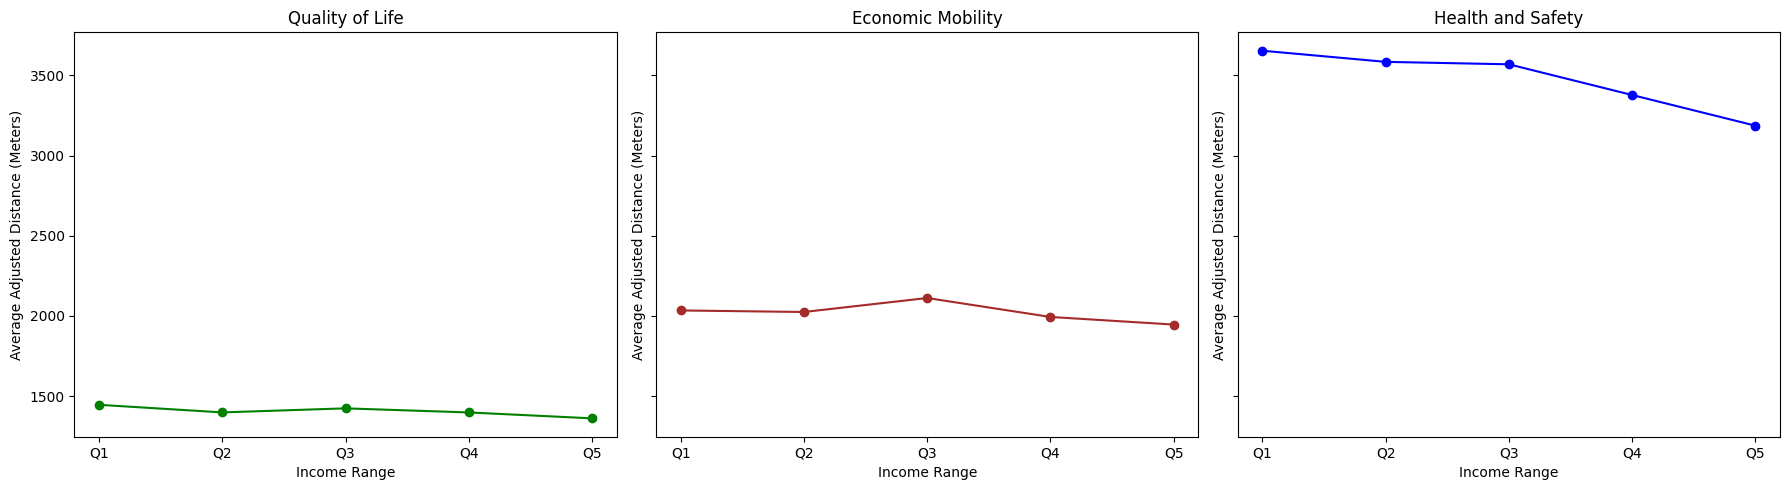

In [199]:
plot_classification_average_trendlines(aggregated_results, classifications)

In [200]:
def aggregate_by_gini_index(results_by_city, categories, cities_to_gini):
    """
    Aggregates amenity distance data across cities and replaces income ranges with city Gini indices.
    
    Parameters:
      - results_by_city: dict of city results.
      - categories: dict mapping category -> list of amenities.
      - cities_to_gini: dict mapping city names to Gini indices.

    Returns:
      aggregated_results: dict where each amenity is now mapped to a DataFrame with:
          gini_index, avg_dist (mean), ci_lower, ci_upper.
    """
    aggregated_results = {}

    for category, items in categories.items():
        aggregated_results[category] = {}

        for item in items:
            city_data = []  # Store city-level results

            for city_name, city_results in results_by_city.items():
                if city_name not in cities_to_gini:
                    continue  # Skip cities without Gini index

                gini = cities_to_gini[city_name]  # Get city's Gini index
                
                try:
                    city_df = city_results[category][item]  # Get amenity data
                    city_df = city_df.replace([np.inf, -np.inf], np.nan).dropna()

                    avg_distance = city_df["avg_dist"].mean()  # Compute mean distance
                    city_data.append({"gini_index": gini, "avg_dist": avg_distance})
                except:
                    continue  # Skip cities missing this amenity

            if city_data:
                # Convert list to DataFrame
                df = pd.DataFrame(city_data)

                # Compute confidence intervals via bootstrapping
                lower_ci = np.percentile(df["avg_dist"], 2.5) if len(df) > 1 else df["avg_dist"].min()
                upper_ci = np.percentile(df["avg_dist"], 97.5) if len(df) > 1 else df["avg_dist"].max()
                
                df["ci_lower"] = lower_ci
                df["ci_upper"] = upper_ci

                # Store results
                aggregated_results[category][item] = df

    return aggregated_results


In [201]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from scipy.stats import linregress

def plot_gini_vs_distance(aggregated_results, categories):
    total_items = sum(len(items) for items in categories.values())
    cols = 3
    rows = math.ceil(total_items / cols)

    fig, axs = plt.subplots(rows, cols, figsize=(15, rows * 5))
    plot_index = 0
    
    rows_cols_by_amenity = {
        "pharmacy": (0, 2, "Health & Safety"),
        "police": (1, 2, "Health & Safety"),
        "hospital": (2, 2, "Health & Safety"),
        "fire_station": (3, 2, "Health & Safety"),
        "school": (0, 1, "Economic Mobility"),
        "bank": (1, 1, "Economic Mobility"),
        "social_facility": (2, 1, "Economic Mobility"),
        "bus_stop": (3, 1, "Economic Mobility"),
        "park": (0, 0, "Quality of Life"),
        "supermarket": (1, 0, "Quality of Life"),
        "place_of_worship": (2, 0, "Quality of Life"),
        "library": (3, 0, "Quality of Life")
    }

    for category, items in categories.items():
        for item in items:
            row, col, cat = rows_cols_by_amenity.get(item, (0, 0, "Other"))
            ax = axs[row, col] if rows > 1 else axs[col]

            # Get the aggregated data
            data = aggregated_results.get(category, {}).get(item, None)
            if data is not None and not data.empty:
                # Sort data by Gini index
                data = data.sort_values("gini_index")

                # Linear regression analysis
                slope, intercept, r_value, p_value, std_err = linregress(data["gini_index"], data["avg_dist"])

                # Generate regression line
                x_vals = np.linspace(data["gini_index"].min(), data["gini_index"].max(), 100)
                y_vals = slope * x_vals + intercept

                # Assign color based on category
                color = "green" if col == 0 else "brown" if col == 1 else "blue"

                # Plot the regression line
                ax.plot(x_vals, y_vals, linestyle="-", color=color, label=f"{item} Trendline")

                # Display regression statistics
                ax.annotate(
                    f"Slope: {slope:.3f}\nR²: {r_value**2:.3f}\nP-value: {p_value:.3e}",
                    xy=(0.05, 0.85), xycoords="axes fraction", fontsize=10,
                    bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3")
                )

                print(f"📊 {category.capitalize()} - {item}:")
                print(f"  Slope: {slope:.3f}")
                print(f"  R-squared: {r_value**2:.3f}")
                print(f"  P-value: {p_value:.3e}")
                print(f"  Std Err: {std_err:.3f}\n")

            ax.set_title(f"{cat}: {item.capitalize()}")
            ax.set_xlabel("Gini Index")
            ax.set_ylabel("Average Adjusted Distance (Meters)")
            plot_index += 1

    for j in range(plot_index, rows * cols):
        fig.delaxes(axs[j // cols, j % cols])

    plt.tight_layout()
    plt.show()



📊 Amenity - library:
  Slope: -25705.065
  R-squared: 0.076
  P-value: 9.310e-02
  Std Err: 14901.502

📊 Amenity - fire_station:
  Slope: -10278.065
  R-squared: 0.027
  P-value: 3.259e-01
  Std Err: 10318.453

📊 Amenity - bank:
  Slope: -6626.050
  R-squared: 0.019
  P-value: 4.108e-01
  Std Err: 7962.237

📊 Amenity - place_of_worship:
  Slope: -7834.647
  R-squared: 0.173
  P-value: 9.509e-03
  Std Err: 2859.767

📊 Amenity - pharmacy:
  Slope: -10361.082
  R-squared: 0.024
  P-value: 3.493e-01
  Std Err: 10924.942

📊 Amenity - social_facility:
  Slope: -27790.032
  R-squared: 0.034
  P-value: 2.675e-01
  Std Err: 24675.647

📊 Amenity - police:
  Slope: -44097.873
  R-squared: 0.078
  P-value: 9.054e-02
  Std Err: 25354.478

📊 Leisure - park:
  Slope: -279.425
  R-squared: 0.000
  P-value: 9.325e-01
  Std Err: 3275.938

📊 Building - school:
  Slope: -10804.929
  R-squared: 0.063
  P-value: 1.278e-01
  Std Err: 6931.163

📊 Building - hospital:
  Slope: -31424.499
  R-squared: 0.039
  P

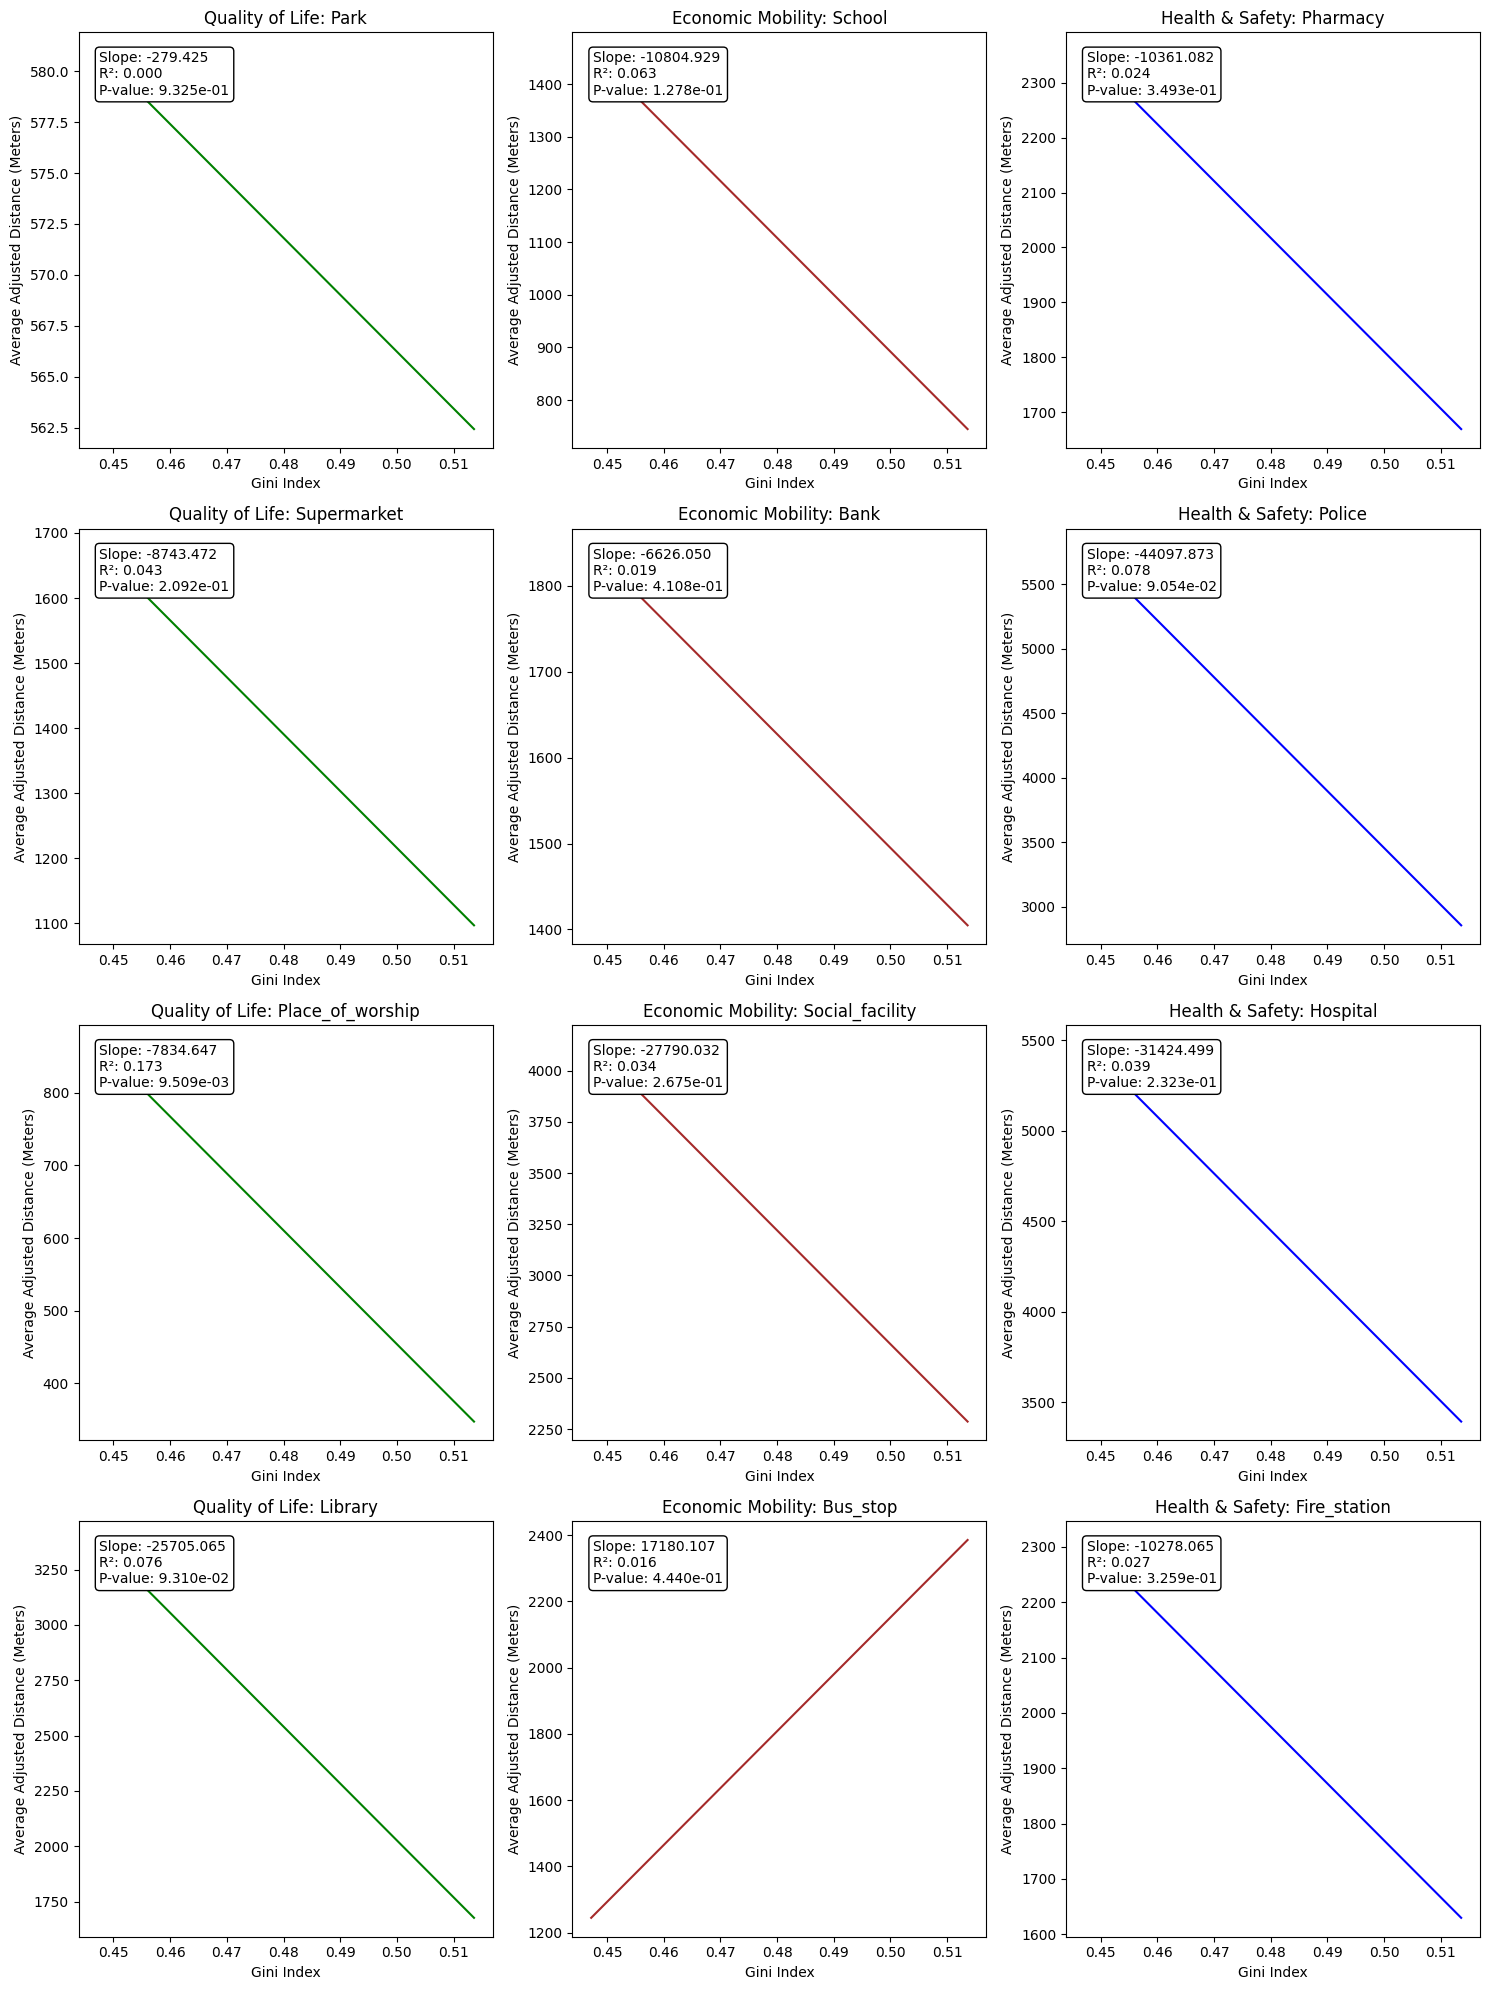

In [202]:
aggregated_results_gini = aggregate_by_gini_index(results_by_city, categories, cities_to_gini)
plot_gini_vs_distance(aggregated_results_gini, categories)

In [203]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from scipy.stats import linregress

def aggregate_category_by_gini(results_by_city, classifications, cities_to_gini):
    """
    Aggregates distance data across cities at the category level (e.g., 'quality-of-life').
    Replaces income quintiles with city Gini indices.

    Parameters:
      - results_by_city: dict of city results.
      - classifications: dict mapping category -> dict of amenities.
      - cities_to_gini: dict mapping city names to Gini indices.

    Returns:
      aggregated_results: dict where each category maps to a DataFrame with:
          gini_index, avg_dist (mean), ci_lower, ci_upper.
    """
    aggregated_results = {}

    for category, amenities in classifications.items():
        category_data = []

        for city_name, city_results in results_by_city.items():
            if city_name not in cities_to_gini:
                continue  # Skip cities without Gini index

            gini = cities_to_gini[city_name]  # Get city's Gini index
            city_avg_distances = []

            for amenity_group, items in amenities.items():
                for item in items:
                    try:
                        city_df = city_results[amenity_group][item]
                        city_df = city_df.replace([np.inf, -np.inf], np.nan).dropna()
                        avg_distance = city_df["avg_dist"].mean()  # Compute mean distance
                        city_avg_distances.append(avg_distance)
                    except:
                        continue  # Skip missing amenities

            if city_avg_distances:
                category_avg_dist = np.mean(city_avg_distances)  # Aggregate across amenities
                category_data.append({"gini_index": gini, "avg_dist": category_avg_dist})

        if category_data:
            # Convert to DataFrame
            df = pd.DataFrame(category_data)

            # Compute confidence intervals
            lower_ci = np.percentile(df["avg_dist"], 2.5) if len(df) > 1 else df["avg_dist"].min()
            upper_ci = np.percentile(df["avg_dist"], 97.5) if len(df) > 1 else df["avg_dist"].max()
            
            df["ci_lower"] = lower_ci
            df["ci_upper"] = upper_ci

            aggregated_results[category] = df

    return aggregated_results

aggregated_results = aggregate_category_by_gini(results_by_city, classifications, cities_to_gini)

📊 Quality-of-life Category:
  Slope: -10640.652
  R-squared: 0.074
  P-value: 9.923e-02
  Std Err: 6287.652

📊 Economic-mobility Category:
  Slope: -7010.226
  R-squared: 0.008
  P-value: 5.947e-01
  Std Err: 13060.300

📊 Health-and-safety Category:
  Slope: -24040.380
  R-squared: 0.064
  P-value: 1.262e-01
  Std Err: 15356.213



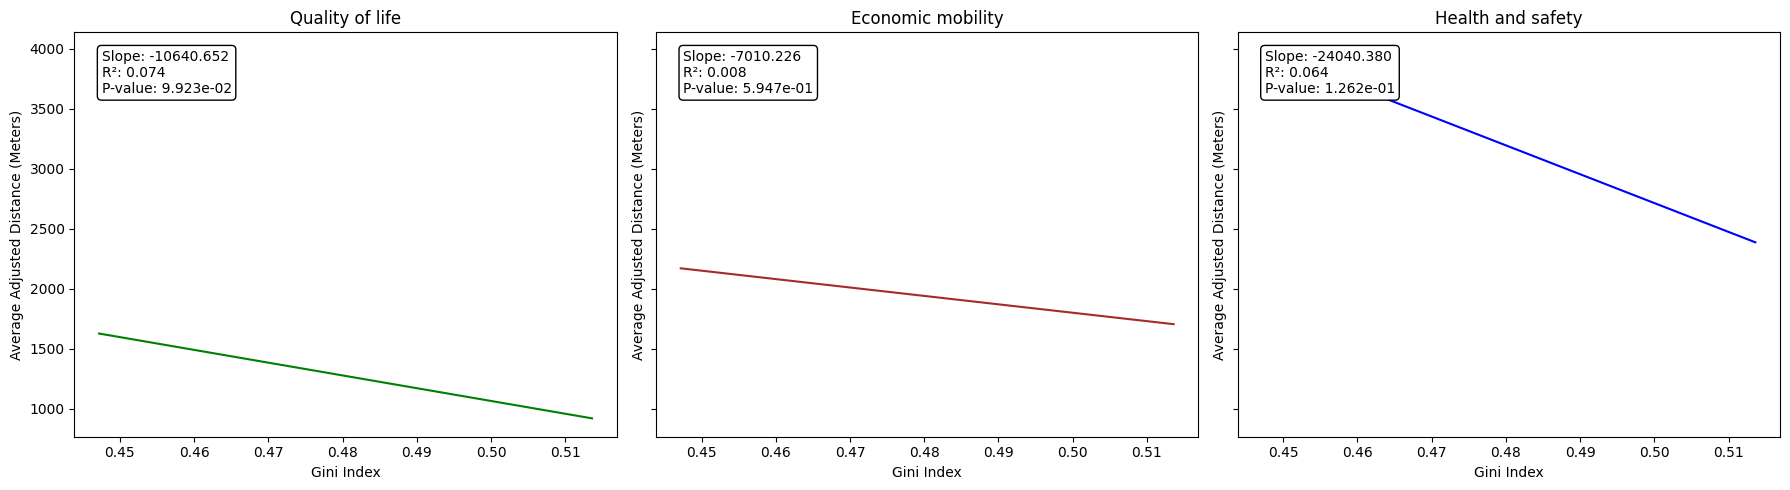

In [204]:
def plot_category_trendlines(aggregated_results):
    """
    Plots Gini Index vs. aggregated amenity distance for each category.
    Only plots the linear trendline and displays statistical significance.

    Parameters:
      - aggregated_results: dict mapping category -> DataFrame of (gini_index, avg_dist).
    """
    classification_names = list(aggregated_results.keys())
    n_class = len(classification_names)

    fig, axs = plt.subplots(1, n_class, figsize=(6 * n_class, 5), sharey=True)
    if n_class == 1:
        axs = [axs]  # Ensure axs is iterable if only one subplot exists.

    for ax, cls in zip(axs, classification_names):
        # Get aggregated category-level data
        data = aggregated_results.get(cls, None)
        if data is None or data.empty:
            ax.set_title(cls.replace("-", " ").capitalize() + "\n(No Data)")
            continue

        # Sort data by Gini index
        data = data.sort_values("gini_index")

        # Linear regression analysis
        slope, intercept, r_value, p_value, std_err = linregress(data["gini_index"], data["avg_dist"])

        # Generate regression line
        x_vals = np.linspace(data["gini_index"].min(), data["gini_index"].max(), 100)
        y_vals = slope * x_vals + intercept

        # Assign color based on category
        color_map = {
            "quality-of-life": "green",
            "economic-mobility": "brown",
            "health-safety": "blue"
        }
        color = color_map.get(cls, "blue")

        # Plot the regression line
        ax.plot(x_vals, y_vals, linestyle="-", color=color, label=f"{cls} Trendline")

        # Display regression statistics
        ax.annotate(
            f"Slope: {slope:.3f}\nR²: {r_value**2:.3f}\nP-value: {p_value:.3e}",
            xy=(0.05, 0.85), xycoords="axes fraction", fontsize=10,
            bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3")
        )

        print(f"📊 {cls.capitalize()} Category:")
        print(f"  Slope: {slope:.3f}")
        print(f"  R-squared: {r_value**2:.3f}")
        print(f"  P-value: {p_value:.3e}")
        print(f"  Std Err: {std_err:.3f}\n")

        ax.set_title(cls.replace("-", " ").capitalize())
        ax.set_xlabel("Gini Index")
        ax.set_ylabel("Average Adjusted Distance (Meters)")

    plt.tight_layout()
    plt.show()

plot_category_trendlines(aggregated_results)

In [205]:
# from Census table B19083
cities_to_gini = {
    "newyork": 0.5136,
    "losangeles": 0.4928,
    "chicago": 0.4817,
    "houston": 0.4827,
    "phoenix": 0.4534,
    "philadelphia": 0.4828,
    "sanantonio": 0.4600,
    "sandiego": 0.4602,
    "dallas": 0.4637,
    "jacksonville": 0.4663,
    "austin": 0.4563,
    "fortworth": 0.4637,
    "sanjose": 0.4743,
    "columbus": 0.4583,
    "charlotte": 0.4749,
    "indianapolis": 0.4655,
    "sanfrancisco": 0.4913,
    "seattle": 0.4620,
    "denver": 0.4482,
    "oklahomacity": 0.4646,
    "nashville": 0.4646,
    "washington": 0.4472,
    "elpaso": 0.4663,
    "lasvegas": 0.4706,
    "boston": 0.4847,
    "detroit": 0.4726,
    "portland": 0.4491,
    "louisville": 0.4624,
    "memphis": 0.4897,
    "baltimore": 0.4603,
    "milwaukee": 0.4710,
    "albuquerque": 0.4668,
    "tucson": 0.4679,
    "fresno": 0.4730,
    "sacramento": 0.4556,
    "mesa": 0.4564,
    "atlanta": 0.4676,
    "kansascity": 0.4518,
}

In [206]:
city_names = cities_to_ids.keys()

class_counts = {}

for city in city_names:
    class_counts[city] = {
        "CCU": {
            "quality-of-life": 0,
            "economic-mobility": 0,
            "health-and-safety": 0,
        },
        "CCD": {
            "quality-of-life": 0,
            "economic-mobility": 0,
            "health-and-safety": 0,
        },
        "LP": {
            "quality-of-life": 0,
            "economic-mobility": 0,
            "health-and-safety": 0,
        },
        "LN": {
            "quality-of-life": 0,
            "economic-mobility": 0,
            "health-and-safety": 0,
        }
    }
    
    for category, items in categories.items():
        for item in items:
            try:
                distances = list(results_by_city[city][category][item]["avg_dist"])
            except:
                continue
            q1 = distances[0]
            q2 = distances[1]
            q3 = distances[2]
            
            if item in classifications["quality-of-life"][category]:
                purpose = "quality-of-life"
            elif item in classifications["economic-mobility"][category]:
                purpose = "economic-mobility"
            else:
                purpose = "health-and-safety"
            
            if q1 > q2 < q3:
                class_counts[city]["CCU"][purpose] += 1
            elif q1 < q2 > q3:
                class_counts[city]["CCD"][purpose] += 1
            elif q1 < q2 < q3:
                class_counts[city]["LP"][purpose] += 1
            elif q1 > q2 > q3:
                class_counts[city]["LN"][purpose] += 1

In [207]:
mux = pd.MultiIndex.from_product([city_names, ["CCU", "CCD", "LP", "LN"], ["quality-of-life", "economic-mobility", "health-and-safety"]])
df = pd.DataFrame(class_counts, columns=mux)

In [208]:
# Flatten the nested dictionary into a DataFrame-friendly format
flattened_data = []

for city, categories in class_counts.items():
    for category, metrics in categories.items():
        for metric, value in metrics.items():
            flattened_data.append((city, category, metric, value))

# Convert to a DataFrame
df = pd.DataFrame(flattened_data, columns=["City", "Category", "Metric", "Value"])

# Pivot to create MultiIndex columns
df_pivot = df.pivot(index="City", columns=["Metric", "Category"], values="Value")

# # Display the resulting DataFrame
# df_pivot

In [209]:
# Flatten and sum the nested dictionary
category_counts = {"CCD": {}, "CCU": {}, "LP": {}, "LN": {}}

for city, categories in class_counts.items():
    
    city_totals = {}
    for category, metrics in categories.items():
        # Sum across all metrics for each category
        category_counts[category][city] = sum(metrics.values())

# Convert to DataFrame
counts_df = pd.DataFrame(category_counts)

# # Display the DataFrame
# counts_df


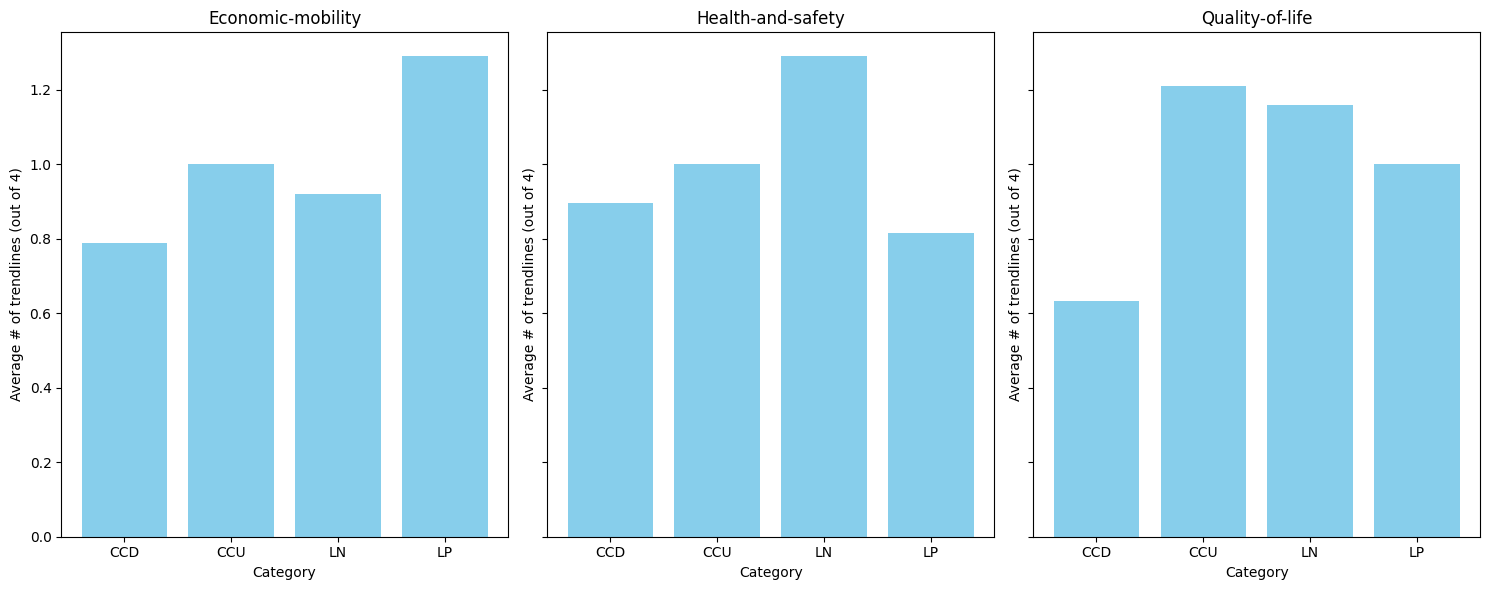

In [210]:
# Average the values grouped by Metric and Category
df_avg = df.groupby(["Metric", "Category"])["Value"].mean().reset_index()

# Unique metrics for separate subplots
metrics = df_avg["Metric"].unique()

# Create a grid of bar plots
fig, axs = plt.subplots(1, len(metrics), figsize=(15, 6), sharey=True)

for i, metric in enumerate(metrics):
    metric_data = df_avg[df_avg["Metric"] == metric]
    axs[i].bar(metric_data["Category"], metric_data["Value"], color='skyblue')
    axs[i].set_title(f"{metric.capitalize()}")
    axs[i].set_xlabel("Category")
    axs[i].set_ylabel("Average # of trendlines (out of 4)")

plt.tight_layout()
plt.show()

In [211]:
cities_to_founding = {
    "newyork": 1624,
    "losangeles": 1781,
    "chicago": 1803,
    "houston": 1837,
    "phoenix": 1868,
    "philadelphia": 1681,
    "sanantonio": 1718,
    "sandiego": 1769,
    "dallas": 1841,
    "jacksonville": 1791,
    "austin": 1835,
    "fortworth": 1849, 
    "sanjose": 1777,
    "columbus": 1812,
    "charlotte": 1755,
    "indianapolis": 1821,
    "sanfrancisco": 1776,
    "seattle": 1851,
    "denver": 1858,
    "oklahomacity": 1889,
    "nashville": 1779,
    "washington": 1790,
    "elpaso": 1659,
    "lasvegas": 1911,
    "boston": 1630,
    "detroit": 1701,
    "portland": 1845,
    "louisville": 1778,
    "memphis": 1819,
    "baltimore": 1729,
    "milwaukee": 1833,
    "albuquerque": 1706,
    "tucson": 1775,
    "fresno": 1872,
    "sacramento": 1848,
    "mesa": 1878, 
    "atlanta": 1843,
    "kansascity": 1838
}

In [212]:
# Add founding date as a new column
df_pivot["Founding Date"] = df_pivot.index.get_level_values("City").map(cities_to_founding)

# Sort by the founding date
df_sorted = df_pivot.reset_index().sort_values(by="Founding Date").set_index(["City"])

# Display the sorted DataFrame
df_sorted.head()

Metric,quality-of-life,economic-mobility,health-and-safety,quality-of-life,economic-mobility,health-and-safety,quality-of-life,economic-mobility,health-and-safety,quality-of-life,economic-mobility,health-and-safety,Founding Date
Category,CCU,CCU,CCU,CCD,CCD,CCD,LP,LP,LP,LN,LN,LN,
City,,,,,,,,,,,,,
newyork,0,0,0,1,3,3,0,0,0,3,1,1,1624
boston,0,1,0,4,3,2,0,0,0,0,0,2,1630
elpaso,2,3,2,1,0,1,0,1,0,1,0,1,1659
philadelphia,1,0,0,2,3,2,1,1,1,0,0,1,1681
detroit,2,0,1,1,0,2,1,3,1,0,1,0,1701


quality-of-life - CCU:
  Slope: 0.001
  Intercept: -0.898
  R-squared: 0.007
  P-value: 6.142e-01
  Std Err: 0.002
quality-of-life - CCD:
  Slope: -0.006
  Intercept: 11.179
  R-squared: 0.261
  P-value: 1.047e-03
  Std Err: 0.002
quality-of-life - LN:
  Slope: 0.003
  Intercept: -4.775
  R-squared: 0.062
  P-value: 1.314e-01
  Std Err: 0.002
quality-of-life - LP:
  Slope: 0.001
  Intercept: -1.506
  R-squared: 0.011
  P-value: 5.353e-01
  Std Err: 0.002
economic-mobility - CCU:
  Slope: 0.002
  Intercept: -2.730
  R-squared: 0.029
  P-value: 3.070e-01
  Std Err: 0.002
economic-mobility - CCD:
  Slope: -0.005
  Intercept: 9.345
  R-squared: 0.132
  P-value: 2.496e-02
  Std Err: 0.002
economic-mobility - LN:
  Slope: 0.005
  Intercept: -7.734
  R-squared: 0.126
  P-value: 2.905e-02
  Std Err: 0.002
economic-mobility - LP:
  Slope: -0.002
  Intercept: 5.120
  R-squared: 0.024
  P-value: 3.544e-01
  Std Err: 0.002
health-and-safety - CCU:
  Slope: 0.003
  Intercept: -4.777
  R-squared: 0.

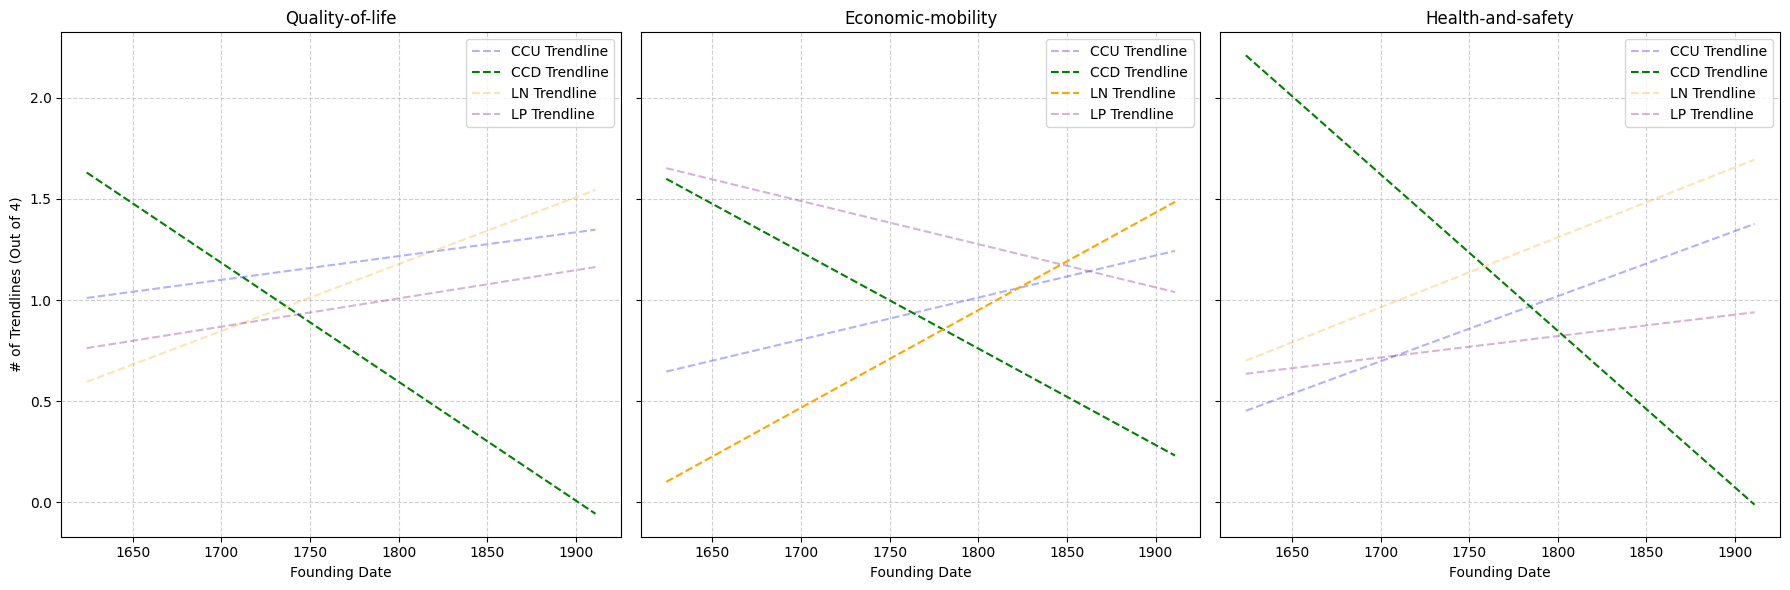

In [213]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Initialize subplots for the three amenities
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# List of amenities (metrics)
amenities = ["quality-of-life", "economic-mobility", "health-and-safety"]

trendlines = ["CCU", "CCD", "LN", "LP"]

# Colors for each category
colors = {"CCU": "blue", "CCD": "green", "LN": "orange", "LP": "purple"}

# Iterate over each amenity to create a subplot
for i, amenity in enumerate(amenities):
    ax = axs[i]
    
    # Filter data for the current amenity
    test_df = df_sorted.loc[:, df_sorted.columns.get_level_values('Metric').isin([amenity, 'Founding Date'])]
    test_df = test_df.loc[:, test_df.columns.get_level_values("Category").isin(trendlines + [''])]

    # Plot trendlines for each category
    for category in trendlines:
        # Extract founding dates and values for the category
        founding_dates = test_df["Founding Date"].values
        values = test_df[(amenity, category)].values.flatten()

        # Perform linear regression
        slope, intercept, r_value, p_value, std_err = linregress(founding_dates, values)

        # Generate trendline
        trendline = slope * founding_dates + intercept
        
        alpha_threshold = 0.05
        
        # Choose full opacity if statistically significant; otherwise, reduce opacity.
        line_alpha = 1.0 if p_value < alpha_threshold else 0.3
        
        ax.plot(founding_dates, trendline, color=colors[category], linestyle='--', label=f"{category} Trendline", alpha=line_alpha)
        
        # Print statistical results
        print(f"{amenity} - {category}:")
        print(f"  Slope: {slope:.3f}")
        print(f"  Intercept: {intercept:.3f}")
        print(f"  R-squared: {r_value**2:.3f}")
        print(f"  P-value: {p_value:.3e}")
        print(f"  Std Err: {std_err:.3f}")
    
    # Customize the subplot
    ax.set_title(f"{amenity.capitalize()}")
    ax.set_xlabel("Founding Date")
    if i == 0:
        ax.set_ylabel("# of Trendlines (Out of 4)")
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [214]:
cities_to_partisanship = {
    "newyork": 100,
    "losangeles": 90,
    "chicago": 90,
    "houston": 0,
    "phoenix": 20,
    "philadelphia": 70,
    "sanantonio": 0,
    "sandiego": 90,
    "dallas": 0,
    "jacksonville": 30,
    "austin": 0,
    "fortworth": 0,
    "sanjose": 90,
    "columbus": 40,
    "charlotte": 10,
    "indianapolis": 10,
    "sanfrancisco": 90,
    "seattle": 10,
    "denver": 60,
    "oklahomacity": 0,
    "nashville": 20,
    "washington": 10,
    "elpaso": 0,
    "lasvegas": 60,
    "boston": 10,
    "detroit": 70,
    "portland": 10,
    "louisville": 20,
    "memphis": 20,
    "baltimore": 90,
    "milwaukee": 80,
    "albuquerque": 80,
    "tucson": 20,
    "fresno": 90,
    "sacramento": 90,
    "mesa": 20,
    "atlanta": 20,
    "kansascity": 2
}

In [215]:
# Add founding date as a new column
df_pivot["Partisanship"] = df_pivot.index.get_level_values("City").map(cities_to_partisanship)

# Sort by the founding date
df_sorted = df_pivot.reset_index().sort_values(by="Partisanship").set_index(["City"])

# Display the sorted DataFrame
df_sorted.head()

Metric,quality-of-life,economic-mobility,health-and-safety,quality-of-life,economic-mobility,health-and-safety,quality-of-life,economic-mobility,health-and-safety,quality-of-life,economic-mobility,health-and-safety,Founding Date,Partisanship
Category,CCU,CCU,CCU,CCD,CCD,CCD,LP,LP,LP,LN,LN,LN,,
City,,,,,,,,,,,,,,
austin,1,3,2,0,0,0,1,1,0,2,0,2,1835,0
houston,1,0,0,0,2,0,1,0,1,2,2,3,1837,0
elpaso,2,3,2,1,0,1,0,1,0,1,0,1,1659,0
dallas,3,2,0,1,0,0,0,0,0,0,2,4,1841,0
fortworth,1,0,0,0,0,0,1,1,0,2,3,4,1849,0


In [216]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Initialize subplots for the three amenities
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# List of amenities (metrics)
amenities = ["quality-of-life", "economic-mobility", "health-and-safety"]

trendlines = ["CCU", "CCD", "LN", "LP"]

# Colors for each category
colors = {"CCU": "blue", "CCD": "green", "LN": "orange", "LP": "purple"}

# Iterate over each amenity to create a subplot
for i, amenity in enumerate(amenities):
    ax = axs[i]
    
    # Filter data for the current amenity
    test_df = df_sorted.loc[:, df_sorted.columns.get_level_values('Metric').isin([amenity, 'Partisanship'])]
    test_df = test_df.loc[:, test_df.columns.get_level_values("Category").isin(trendlines + [''])]

    # Plot trendlines for each category
    for category in trendlines:
        # Extract population and values for the category
        populations = test_df["Partisanship"].values
        values = test_df[(amenity, category)].values.flatten()

        # Perform linear regression
        slope, intercept, r_value, p_value, std_err = linregress(populations, values)

        # Generate trendline
        trendline = slope * populations + intercept
        
        alpha_threshold = 0.05
        
        # Choose full opacity if statistically significant; otherwise, reduce opacity.
        line_alpha = 1.0 if p_value < alpha_threshold else 0.3
        
        ax.plot(populations, trendline, color=colors[category], linestyle='--', label=f"{category} Trendline", alpha=line_alpha)
        
        # Print statistical results
        print(f"{amenity} - {category}:")
        print(f"  Slope: {slope:.3f}")
        print(f"  Intercept: {intercept:.3f}")
        print(f"  R-squared: {r_value**2:.3f}")
        print(f"  P-value: {p_value:.3e}")
        print(f"  Std Err: {std_err:.3f}")
    
    # Customize the subplot
    ax.set_title(f"{amenity.capitalize()}")
    ax.set_xlabel("Percent Presidential Elections with Democrat Majority (Last 10 Elections)")
    if i == 0:
        ax.set_ylabel("# of Trendlines (Out of 4)")
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


quality-of-life - CCU:
  Slope: 0.002
  Intercept: 1.116
  R-squared: 0.008
  P-value: 5.972e-01
  Std Err: 0.004
quality-of-life - CCD:
  Slope: 0.002
  Intercept: 0.533
  R-squared: 0.013
  P-value: 5.039e-01
  Std Err: 0.004
quality-of-life - LN:
  Slope: -0.001
  Intercept: 1.206
  R-squared: 0.002
  P-value: 7.789e-01
  Std Err: 0.004
quality-of-life - LP:
  Slope: -0.004
  Intercept: 1.145
  R-squared: 0.020
  P-value: 3.997e-01
  Std Err: 0.004
economic-mobility - CCU:
  Slope: -0.004
  Intercept: 1.175
  R-squared: 0.035
  P-value: 2.610e-01
  Std Err: 0.004
economic-mobility - CCD:
  Slope: 0.004
  Intercept: 0.641
  R-squared: 0.022
  P-value: 3.764e-01
  Std Err: 0.004
economic-mobility - LN:
  Slope: -0.003
  Intercept: 1.024
  R-squared: 0.010
  P-value: 5.553e-01
  Std Err: 0.004
economic-mobility - LP:
  Slope: 0.003
  Intercept: 1.160
  R-squared: 0.015
  P-value: 4.642e-01
  Std Err: 0.004
health-and-safety - CCU:
  Slope: 0.001
  Intercept: 0.970
  R-squared: 0.001
  

KeyboardInterrupt: 

In [ ]:
cities_to_distance = {
    "newyork": 40.6943,
    "losangeles": 34.1141,
    "chicago": 41.8375,
    "houston": 29.786,
    "phoenix": 33.5722,
    "philadelphia": 40.0077,
    "sanantonio": 29.4632,
    "sandiego": 33.0094,
    "dallas": 32.7935,
    "jacksonville": 30.3322,
    "austin": 30.3005,
    "fortworth": 32.7817,
    "sanjose": 37.3012,
    "columbus": 39.9862,
    "charlotte": 35.2083,
    "indianapolis": 39.7771,
    "sanfrancisco": 37.7558,
    "seattle": 47.6211,
    "denver": 39.762,
    "oklahomacity": 35.4676,
    "nashville": 36.1715,
    "washington": 38.9047,
    "elpaso": 31.8476,
    "lasvegas": 36.2333,
    "boston": 42.3188,
    "detroit": 42.3834,
    "portland": 45.5371,
    "louisville": 38.1663,
    "memphis": 35.1087,
    "baltimore": 39.3051,
    "milwaukee": 43.0642,
    "albuquerque": 35.1054,
    "tucson": 32.1541,
    "fresno": 36.783,
    "sacramento": 38.5677,
    "mesa": 33.4015,
    "atlanta": 33.7628,
    "kansascity": 39.1238,
}

In [ ]:
# Add founding date as a new column
df_pivot["Distance"] = df_pivot.index.get_level_values("City").map(cities_to_distance)

# Sort by the founding date
df_sorted = df_pivot.reset_index().sort_values(by="Distance").set_index(["City"])

# Display the sorted DataFrame
df_sorted.head()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Initialize subplots for the three amenities
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# List of amenities (metrics)
amenities = ["quality-of-life", "economic-mobility", "health-and-safety"]

# Colors for each category
colors = {"CCU": "blue", "CCD": "green", "LN": "orange", "LP": "purple"}

# Iterate over each amenity to create a subplot
for i, amenity in enumerate(amenities):
    ax = axs[i]
    
    # Filter data for the current amenity
    test_df = df_sorted.loc[:, df_sorted.columns.get_level_values('Metric').isin([amenity, 'Distance'])]
    test_df = test_df.loc[:, test_df.columns.get_level_values("Category").isin(trendlines + [''])]
    
    # Plot trendlines for each category
    for category in trendlines:
        # Extract founding dates (Distance) and values for the category
        founding_dates = test_df["Distance"].values
        values = test_df[(amenity, category)].values.flatten()

        # Perform linear regression
        slope, intercept, r_value, p_value, std_err = linregress(founding_dates, values)
        
        # Generate trendline
        trendline = slope * founding_dates + intercept
        
        alpha_threshold = 0.05
        
        # Choose full opacity if statistically significant; otherwise, reduce opacity.
        line_alpha = 1.0 if p_value < alpha_threshold else 0.3
        
        ax.plot(founding_dates, trendline, color=colors[category], linestyle='--', label=f"{category} Trendline", alpha=line_alpha)
        
        # Display statistical information in console
        print(f"{amenity} - {category}:")
        print(f"  Slope: {slope:.3f}")
        print(f"  Intercept: {intercept:.3f}")
        print(f"  R-squared: {r_value**2:.3f}")
        print(f"  P-value: {p_value:.3e}")
        print(f"  Std Err: {std_err:.3f}")
    
    # Customize the subplot
    ax.set_title(f"{amenity.capitalize()}")
    ax.set_xlabel("Latitude")
    if i == 0:
        ax.set_ylabel("# of Trendlines (Out of 4)")
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [ ]:
# from Census table B19083
cities_to_gini = {
    "newyork": 0.5136,
    "losangeles": 0.4928,
    "chicago": 0.4817,
    "houston": 0.4827,
    "phoenix": 0.4534,
    "philadelphia": 0.4828,
    "sanantonio": 0.4600,
    "sandiego": 0.4602,
    "dallas": 0.4637,
    "jacksonville": 0.4663,
    "austin": 0.4563,
    "fortworth": 0.4637,
    "sanjose": 0.4743,
    "columbus": 0.4583,
    "charlotte": 0.4749,
    "indianapolis": 0.4655,
    "sanfrancisco": 0.4913,
    "seattle": 0.4620,
    "denver": 0.4482,
    "oklahomacity": 0.4646,
    "nashville": 0.4646,
    "washington": 0.4472,
    "elpaso": 0.4663,
    "lasvegas": 0.4706,
    "boston": 0.4847,
    "detroit": 0.4726,
    "portland": 0.4491,
    "louisville": 0.4624,
    "memphis": 0.4897,
    "baltimore": 0.4603,
    "milwaukee": 0.4710,
    "albuquerque": 0.4668,
    "tucson": 0.4679,
    "fresno": 0.4730,
    "sacramento": 0.4556,
    "mesa": 0.4564,
    "atlanta": 0.4676,
    "kansascity": 0.4518,
}

In [ ]:
# Add founding date as a new column
df_pivot["Gini"] = df_pivot.index.get_level_values("City").map(cities_to_gini)

# Sort by the founding date
df_sorted = df_pivot.reset_index().sort_values(by="Gini").set_index(["City"])

# # Display the sorted DataFrame
# df_sorted.head()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Initialize subplots for the three amenities
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# List of amenities (metrics)
amenities = ["quality-of-life", "economic-mobility", "health-and-safety"]

# Colors for each category
colors = {"CCU": "blue", "CCD": "green", "LN": "orange", "LP": "purple"}

# Iterate over each amenity to create a subplot
for i, amenity in enumerate(amenities):
    ax = axs[i]
    
    # Filter data for the current amenity
    test_df = df_sorted.loc[:, df_sorted.columns.get_level_values('Metric').isin([amenity, 'Gini'])]
    test_df = test_df.loc[:, test_df.columns.get_level_values("Category").isin(trendlines + [''])]
    
    # Plot trendlines for each category
    for category in trendlines:
        # Extract founding dates (Distance) and values for the category
        founding_dates = test_df["Gini"].values
        values = test_df[(amenity, category)].values.flatten()

        # Perform linear regression
        slope, intercept, r_value, p_value, std_err = linregress(founding_dates, values)
        
        # Generate trendline
        trendline = slope * founding_dates + intercept
        
        alpha_threshold = 0.05
        
        # Choose full opacity if statistically significant; otherwise, reduce opacity.
        line_alpha = 1.0 if p_value < alpha_threshold else 0.3
        
        ax.plot(founding_dates, trendline, color=colors[category], linestyle='--', label=f"{category} Trendline", alpha=line_alpha)
        
        # Display statistical information in console
        print(f"{amenity} - {category}:")
        print(f"  Slope: {slope:.3f}")
        print(f"  Intercept: {intercept:.3f}")
        print(f"  R-squared: {r_value**2:.3f}")
        print(f"  P-value: {p_value:.3e}")
        print(f"  Std Err: {std_err:.3f}")
    
    # Customize the subplot
    ax.set_title(f"{amenity.capitalize()}")
    ax.set_xlabel("Gini Index")
    if i == 0:
        ax.set_ylabel("# of Trendlines (Out of 4)")
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()